In [1]:
%matplotlib inline

In [2]:
import itertools
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.fft import rfft, rfftfreq
from scipy.signal import argrelmin
from tqdm.notebook import tqdm

In [3]:
from types import SimpleNamespace

import scipy.constants

###################################################################
# Units
# Length : nm
# Energy : meV
# Current : nA
# Temperature : K

constants = SimpleNamespace(
    hbar=scipy.constants.hbar,
    m_e=scipy.constants.m_e,
    eV=scipy.constants.eV,
    e=scipy.constants.e,
    meV=scipy.constants.eV * 1e-3,
    k_B=scipy.constants.k / (scipy.constants.eV * 1e-3),
    mu_B=scipy.constants.physical_constants["Bohr magneton"][0]
    / (scipy.constants.eV * 1e-3),
    current_unit=scipy.constants.k * scipy.constants.e / scipy.constants.hbar * 1e9,
)

In [4]:
plt.style.use("../../sans_style.mplstyle")
plt.close("all")


pd_cmap = mpl.colors.ListedColormap(
    ["darkorange", "gold", "lightgreen", "lightseagreen"]
)
line_colors = [
    "xkcd:bright sky blue",
    "xkcd:cobalt blue",
    "xkcd:bright purple",
    "xkcd:bordeaux",
]


def add_tl_label(ax, text, color=[1, 1, 1, 0.90]):
    ax.text(
        0.03,
        0.96,
        text,
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
    )

In [5]:
simname = "Fig5c"

a_label = r"$h_L / \Delta$ "
b_label = r"$h_R / \Delta$"

Delta_0 = 0.250
a_scale = Delta_0
b_scale = Delta_0

In [6]:
ds = xr.open_dataset(f"./output/{simname}/{simname}.nc")

ws = ds["ws"]
a_N, b_N, theta_N, k = ws.shape

a_ax = ds.coords["a"].to_numpy()
b_ax = ds.coords["b"].to_numpy()

a, b = np.meshgrid(a_ax, b_ax, indexing="ij")

theta_ax = ds.coords["theta"].to_numpy()
theta_N = theta_ax.shape[0]
dtheta = theta_ax[1] - theta_ax[0]

In [7]:
def logcosh(x):
    ax = np.abs(x)
    return ax if ax > 2 else np.log(2 * np.cosh(x))


logcosh = np.frompyfunc(logcosh, 1, 1)

In [8]:
# Set the temperature
T = 20e-3  # mK

f = -(constants.k_B * T) * logcosh(ws / (2 * constants.k_B * T))
F = np.sum(f, axis=-1)

F.name = "F"

In [9]:
arm = argrelmin(F.to_numpy(), axis=-1, order=1, mode="wrap")

mins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]
vmins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]

for n in range(len(arm[0])):
    i = arm[0][n]
    j = arm[1][n]
    n = arm[2][n]

    mins_list[i][j].append(theta_ax[n])
    vmins_list[i][j].append(F[i, j, n])

In [10]:
pd = np.zeros((a_N, b_N)) * np.nan
pdm = np.zeros((a_N, b_N)) * np.nan
pdf = np.zeros((a_N, b_N)) * np.nan

for i, j in tqdm(np.ndindex(a_N, b_N), total=a_N * b_N):

    if len(mins_list[i][j]) == 1:
        if abs(mins_list[i][j][0]) < abs(mins_list[i][j][0] - np.pi):
            pd[i][j] = 0
        else:
            pd[i][j] = 3.14

    elif len(mins_list[i][j]) == 2:
        vmmin = np.argmin(vmins_list[i][j])
        mmin = mins_list[i][j][vmmin]

        if abs(mmin) < abs(mmin - np.pi):
            pd[i][j] = 3.14 / 3
        else:
            pd[i][j] = 2 * 3.14 / 3

    else:
        pd[i][j] = np.mean(mins_list[i][j])
    pdm[i][j] = np.mean(mins_list[i][j])
    pdf[i][j] = mins_list[i][j][0]

  0%|          | 0/17161 [00:00<?, ?it/s]

In [11]:
_I = (np.roll(F.to_numpy(), -1, axis=-1) - F.to_numpy()) / dtheta
_I *= 2 * constants.e / constants.hbar * constants.meV * 1e9

_I_c = np.zeros((a_N, b_N))
for i, j in np.ndindex(a_N, b_N):
    _I_c[i, j] = _I[i, j, np.argmax(np.abs(_I[i, j, : theta_N // 2]), axis=-1)]

I = xr.zeros_like(F)
I[:, :, :] = _I

I_c = xr.DataArray(_I_c, dims=("a", "b"), coords={"a": a_ax, "b": b_ax})

I_0 = 2 * constants.e * Delta_0 / constants.hbar * constants.meV * 1e9

In [12]:
N = F.shape[-1]

ks = rfftfreq(N, 1 / N)
F_k = 2.0 / N * rfft(F)
cF_k = +F_k.real
sF_k = -F_k.imag

In [13]:
a_coord = 7
b_coord = 78

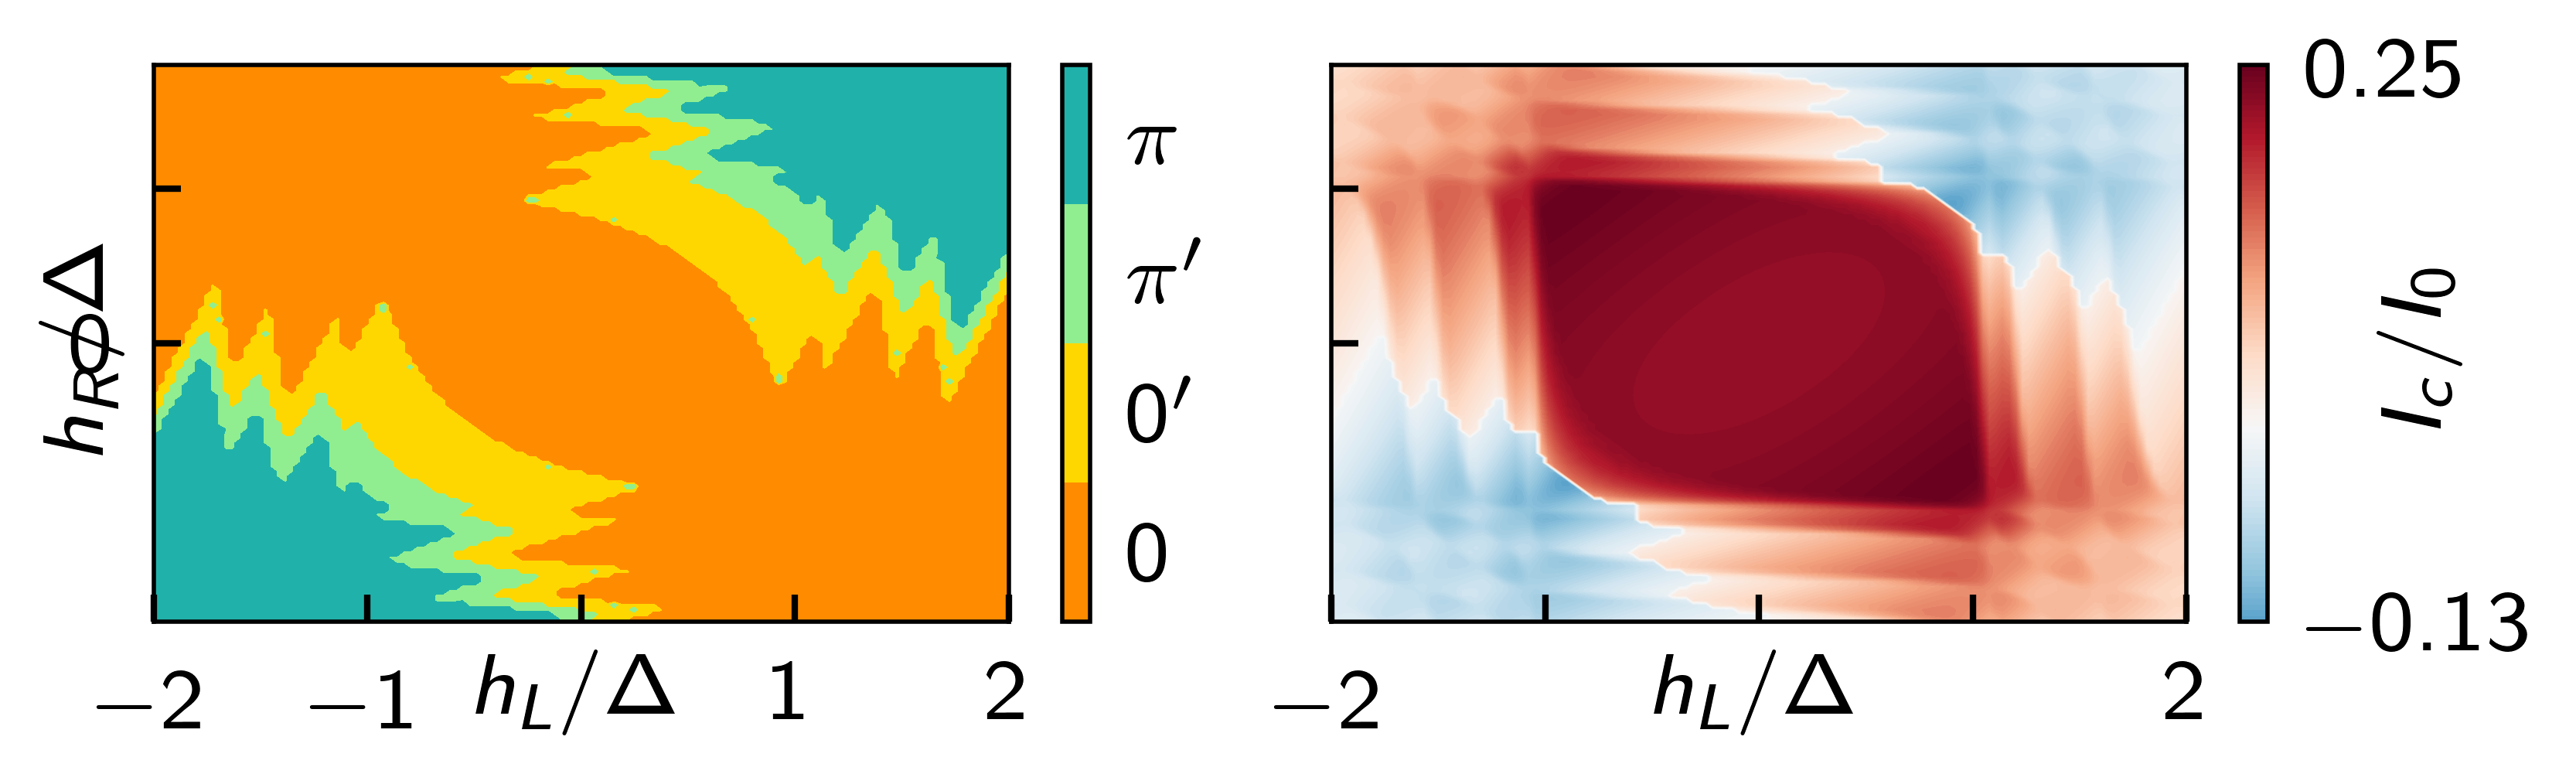

In [14]:
fig, (ax1, ax2) = plt.subplots(
    dpi=1000, figsize=(3.375, 3.375 * 0.3), ncols=2, nrows=1
)

ax1.set_rasterization_zorder(0)
ax2.set_rasterization_zorder(0)
#ax3.set_rasterization_zorder(0)
#ax4.set_rasterization_zorder(0)

levels = np.linspace(0, 3.2, 5)

im = ax1.contourf(a / a_scale, b / b_scale, pd, levels=levels, cmap=pd_cmap, zorder=-30)

cbar1 = fig.colorbar(im, ax=ax1)
cbar1.set_ticks([1 / 8 * 3.2, 3 / 8 * 3.2, 5 / 8 * 3.2, 7 / 8 * 3.2])
cbar1.set_ticklabels([r"$0$", r"$0'$", r"$\pi'$", r"$\pi$"])
cbar1.ax.tick_params(length=0)

im = ax2.contourf(
    a / a_scale,
    b / b_scale,
    I_c / I_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(),
    cmap="RdBu_r",
    zorder=-30,
)
cbar2 = fig.colorbar(im, ax=ax2)
cbar2.set_ticks(
    [np.around(I_c.min() / I_0, decimals=2), np.around(I_c.max() / I_0, decimals=2)]
)
cbar2.ax.tick_params(length=0)
cbar2.set_label(r"$I_c / I_0$", labelpad=-15)
cbar2.ax.tick_params(length=0)


ax1.set_xticks([-2, -1, 0, 1, 2], labels=[r"$-2$", r"$-1$", r"", r"$1$", r"$2$"])
ax1.set_xlabel(a_label, labelpad=-8)
ax1.set_yticks([0, 1, 2], labels=[r"$0$", r"", r"$2$"])
ax1.set_ylabel(b_label, labelpad=-5)

ax2.set_xticks([-2, -1, 0, 1, 2], labels=[r"$-2$", r"", r"", r"", r"$2$"])
ax2.set_xlabel(a_label, labelpad=-8)
ax2.set_yticks([ 0, 1, 2], labels=[])
ax2.set_ylabel("")

ax1.set_ylim(-1.8, 1.8)
ax2.set_ylim(-1.8, 1.8)

fig.tight_layout(pad=0.5)
fig.savefig(f"{simname}.svg")